In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
data = pd.read_csv("data/pokemon_labels.csv")
data

,id,label
0,data/images/Zapdos/c3f34230c7e24d18845c4d2eaad...,Zapdos
1,data/images/Zapdos/f5a52cd93f924e28a46d7def326...,Zapdos
2,data/images/Zapdos/26b19f8809ce496eae2e1b822d5...,Zapdos
3,data/images/Zapdos/7a63f55b762a4fe7b6cd92f17ea...,Zapdos
4,data/images/Zapdos/0b9b5e421d8949e0b2b6698c8d0...,Zapdos
...,...,...
10837,data/images/Farfetchd/c092b8adffcb4fa3a708d7b6...,Farfetchd
10838,data/images/Farfetchd/d4393ad4fcd24f389b8a554f...,Farfetchd
10839,data/images/Farfetchd/6293a3eb9acb461ca4414815...,Farfetchd
10840,data/images/Farfetchd/0ebb1e766b2643c485d8576a...,Farfetchd


In [12]:
pokemon_list = list(data["label"].unique())

In [14]:
data_label = data["label"]
boolean_data_label = [label == np.array(pokemon_list) for label in data_label]

In [16]:
X = list(data["id"].values)
y = boolean_data_label

In [17]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [18]:
IMG_SIZE = 224

def process_image(image_path,img_size=IMG_SIZE):
    """
    Take an image file path and turn image into a Tensor.
    """
    image = tf.io.read_file(image_path) # Read image file
    image = tf.image.decode_jpeg(image,channels=3) # Turn the image into 3 channels RGB
    image = tf.image.convert_image_dtype(image,tf.float32) # Turn the value 0-255 to 0-1
    image = tf.image.resize(image,size=[img_size,img_size]) # Resize the image to 224x224
    return image 

In [19]:
def get_image_label(image_path,label):
    """
    Take an image file path name and the associated label,
    process the image and return a tuple of (image,label)
    """
    image = process_image(image_path)
    return image,label

In [20]:
BATCH_SIZE = 32

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X) and lebel (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating testing data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only file path (no label)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    # If the data is valid dataset, we don't have to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

In [21]:
# Create training and validation data batches
train_data = create_data_batches(X=X_train,y=y_train)
val_data = create_data_batches(X=X_test,y=y_test,valid_data=True)

Creating training data batches...
Creating validation data batches...


In [22]:
import matplotlib.pyplot as plt

def show_25_images(images,labels,predicted):
    """
    Display a plot of 25 images and their labels from a batch.
    """
    plt.figure(figsize=(15,10))
    for i in range(25):
        if apparel_list[labels[i].argmax()] == apparel_list[predicted[i].argmax()]:
            color = 'blue'
        else:
            color = 'red'
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(apparel_list[labels[i].argmax()],color=color)
        plt.axis("off")

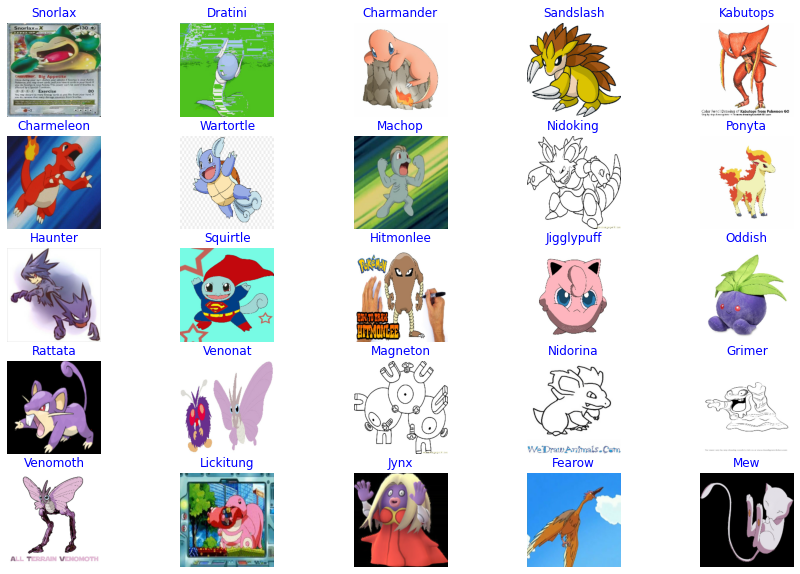

In [29]:
train_images,train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels,train_labels)

In [30]:
NUN_EPOCHS = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE = 6
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
    print(f"Building model with: {model_url}")
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1: Input layer
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax")]) # Layer 2: Output layer
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])
    model.build(input_shape)
    return model

In [31]:
import datetime

def create_tensorboard_callback():
    logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)
NUM_EPOCHS = 20

def train_model():
    """
    Train a given model and return the trained version.
    """
    model = create_model() # Create a model
    model.summary()
    tensorboard = create_tensorboard_callback() # Create tensorboard callback
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping]) # Fit the model passing it the callback we created
    return model

In [ ]:
model = train_model()

In [ ]:
model.save("models/pokemon-classification.h5")

In [ ]:
test_predicted = model.predict(val_data)

In [ ]:
list_predicted = [l.argmax() for l in np.round(test_predicted)]
list_y_test = [l.argmax() for l in y_test]

In [ ]:
from sklearn.metrics import accuracy_score

print(f"The accuracy: {accuracy_score(list_predicted,list_y_test)*100:.2f}")

In [ ]:
show_25_images(val_images,y_test,test_predicted)